In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, plot_precision_recall_curve
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, Binarizer
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import average_precision_score
import seaborn as sns
from sklearn.impute import SimpleImputer
import sys, os
from scipy.sparse import hstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
# import tensorflow
# import torch
# import keras
#import theano
# import statsmodels.formula.api as smf

%matplotlib inline

### Random Forest and Logistic Regression modeling of loan status.

In [2]:
loan_data = pd.read_csv('classification_loan_data.csv',index_col=False)

#Still contains missing values; first, drop features with missing values (dropping samples leaves us with no data).
loan_data = loan_data.dropna(axis=1)

Need to take into consideration the time dependence element of this problem. Because we want to predict whether or not
to issue a loan, need to take into consideration the time series nature of the issuance date. The main consideration is during the cross-validation process later but reorder the data now as it will later be transformed by one-hot encoding. Specifically, it will be stored in a sparse matrix which is harder to manipulate.

In [3]:
loan_data = loan_data.loc[pd.to_datetime(loan_data.issue_d).sort_values().index,:]

In [4]:
# Assign target/training variables
y = loan_data.loan_status
X = loan_data.drop(columns=['loan_status'])

In [5]:
# Function that combines different classification metrics to avoid repeated large blocks of code.
# Produces the confusion matrix, classification report (precision, recall, f1-score,..)
# ROC-AUC and ROC curve
# Precision-recall curve

def classifier_analysis(clf, X_test, y_test):
    y_predict = clf.predict(X_test)
    y_predict_proba= clf.predict_proba(X_test)[:,1]

    _ = ConfusionMatrixDisplay(confusion_matrix(y_test, y_predict)/len(y_test), ['True','False']).plot()

    crprt = classification_report(y_test, y_predict)
    print(crprt)

    logit_roc_auc = roc_auc_score(y_test, y_predict)
    fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=(clf.__class__.__name__ + '(area = %0.2f)' % logit_roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

    average_precision = average_precision_score(y_test, y_predict)
    precision, recall, thresholds = precision_recall_curve(y_test, y_predict)
    disp = plot_precision_recall_curve(clf, X_test, y_test)
    disp.ax_.set_ylim([0.0, 1.0])
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
    return None

Results:
 Not dropping NaN, and using scaling seems to be the "best"? It at least converges. Trying to manually drop features seems to perform terribly. 
 
In order to avoid re-use of the data set, must refrain from setting random state. 

"Best" results are from non-convergent model; this is an indication of unreliability?

Two main preprocessing operations need to be done:

    1. Convert continuous numerical data to discrete by means of KBinsDiscretizer.
    2. Convert categorical data to discrete numerical data by means of OneHotEncoder.

Need to rescale using training data only, but there are multiple cross validation train-test splits so
I think the easiest way of handling this is with a pipeline?

So should the pipeline be
    
    X --> numerical  -->  kbins--------->GridSearchCV(Pipeline(StandardScaler, classifier),param_grid) ?
      \-> categorical-->  onehot--/
      
Intuitively I feel like I should only be rescaling the numerical data; but this cannot be done before splitting into train/test

Also seen Pipeline(StandardScalar, GridSearchCV) but that seems wrong to me and has issues with refitting
    
    "refit : boolean, default=True Refit the best estimator with the entire dataset. If “False”, it is impossible to make predictions using this GridSearchCV instance after fitting."

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.20, random_state=42)

Before anything else; the data can be imbalanced so standard rescaling is applied to the continuous numerical data.

In [7]:
numerical_X_train, numerical_X_test = X_train.select_dtypes(exclude='object'), X_test.select_dtypes(exclude='object')
cat_X_train, cat_X_test = X_train.select_dtypes(include='object').astype('category'), X_test.select_dtypes(include='object').astype('category')
sclr = StandardScaler()
numerical_X_train_scaled = sclr.fit_transform(numerical_X_train)
numerical_X_test_scaled = sclr.transform(numerical_X_test)

Apply KBinsDiscretizer to the rescaled continuous numerical data. The distribution of values
is highly localized on one value for some features. The deafult strategy of KBinsDiscretizer is to bin samples by quantiles so that each bin has an equal number of samples. Because of the localized distribution, however, this creates numerically unviable bin sizes. To manage this the uniform binning strategy is chosen. This, instead of ensuring equal sample sizes, makes the bin sizes uniform.

In [10]:
# Should this be done on only training set? It can change the bins I suppose.
kbd = KBinsDiscretizer(strategy='uniform')
numerical_X_train_sparse = kbd.fit_transform(numerical_X_train_scaled)
numerical_X_test_sparse = kbd.transform(numerical_X_test_scaled)

The one hot encoding can throw an error if there are categories in the test set not in the train set; as the categories are
quantities known before hand it should be ok to pass to the encoder; or does this contaminate the test data?

In [11]:
unique_categories = [np.array(X[col].sort_values().unique().tolist()) for col in X.select_dtypes(include='object').columns]

ohenc = OneHotEncoder(categories=unique_categories)
cat_X_train_sparse = ohenc.fit_transform(cat_X_train)
cat_X_test_sparse = ohenc.transform(cat_X_test)

In [13]:
X_train = hstack((numerical_X_train_sparse, cat_X_train_sparse))
X_test = hstack((numerical_X_test_sparse, cat_X_test_sparse))

To check that everything is formatted correctly; make a test run with each classifier.

In [ ]:
make_pipeline(StandardScaler(), RandomForestClassifier(class_weight='balanced', n_estimators=10))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    114497
           1       0.98      0.80      0.88     20177

    accuracy                           0.97    134674
   macro avg       0.97      0.90      0.93    134674
weighted avg       0.97      0.97      0.97    134674



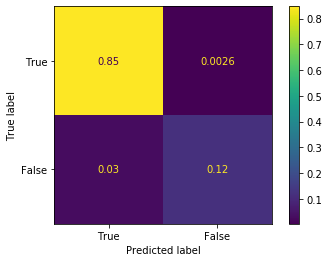

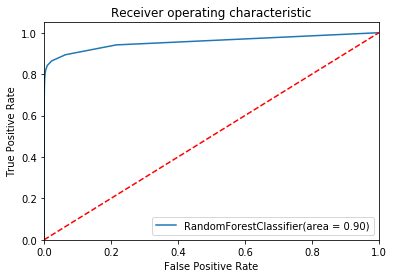

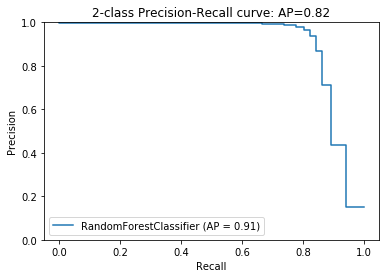

In [14]:
ranfor1 = RandomForestClassifier(class_weight='balanced', n_estimators=10)
ranfor1.fit(X_train, y_train)
classifier_analysis(ranfor1, X_test, y_test)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    114497
           1       0.79      0.89      0.84     20177

    accuracy                           0.95    134674
   macro avg       0.88      0.93      0.90    134674
weighted avg       0.95      0.95      0.95    134674



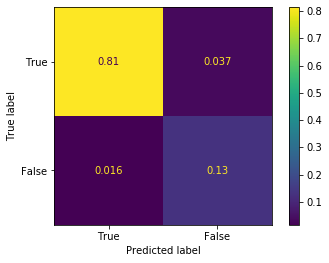

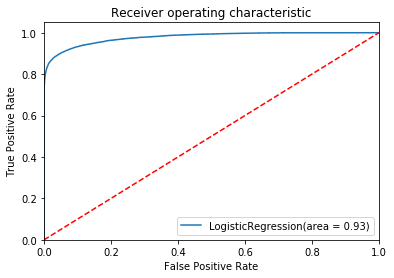

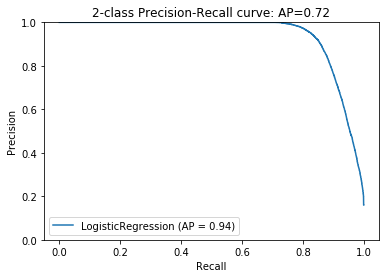

In [15]:
logreg1 = LogisticRegression(class_weight='balanced', solver='saga')
logreg1.fit(X_train, y_train)
classifier_analysis(logreg1, X_test, y_test)

In [14]:
ranfor_param_grid={'n_estimators':[5,10,15]}

ranfor_cv = RandomForestClassifier(class_weight='balanced')
ranfor_model_ = GridSearchCV(ranfor_cv, ranfor_param_grid, cv=TimeSeriesSplit(n_splits=3))
ranfor_model_.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
classifier_analysis(ranfor_model_, X_test, y_test)

In [ ]:
logreg_param_grid = {'tol':[1e-1, 1e-2, 1e-4]}
logreg_cv = LogisticRegression(class_weight='balanced', solver='saga')
logreg_model_ = GridSearchCV(logreg_cv, param_grid, cv=TimeSeriesSplit(n_splits=3))
logreg_model_.fit(X_train, y_train)

In [ ]:
classifier_analysis(logreg_model_, X_test, y_test)